<h2 style='text-align: center;'>AIPM -  MiniProject - CH22M503</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
    - Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
    - Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

<h2 style='text-align: center;'>Kalman Filter - 2nd Version</h2>

#### Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Reference used 

#### Loading the data

In [2]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
display(tank_measurement_data)

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145
...,...,...,...,...
9996,12.262968,12.783158,1.633941,1.409045
9997,12.262968,12.783158,1.633941,1.409045
9998,12.262968,12.783158,1.633941,1.409045
9999,12.262968,12.783158,1.633941,1.409045


#### Seperate each tank measurement 

In [3]:
# Separate the measurements for each tank
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [4]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


#### Common variable declaration

In [5]:
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
time_steps_10000 = np.arange(len(tank1_measurements) - 1)
# Measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
# Variable holding the number of tanks for this excercise
num_tanks = measurements.shape[1]
# Variable to store the number of voltage source in the excercise
num_voltage_source = 2
# Number of measurement availables
num_measurements = len(measurements)
# Initialize lists to store values for plotting
X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list = [],[],[],[],[]
# Flag to track L2 norm convergence
l2_norm_converged = False  

#### Variable declaration for - Kalman Filter

In [ ]:
# Simulation of Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero
# Karl Henrik Johansson. Parameter Initialization

# Base variables required for further parameter initialization
h = tank_measurement_data.to_numpy()[0,:]
Ar = [28, 32, 28, 32]
ar = [0.071, 0.057, 0.071, 0.057]
g = 981.2
gamma_1, gamma_2= 0.7, 0.6
k1, k2 = 3.33, 3.35
kc=0.5

#Time constant measurement
T = [(Ar[i] / ar[i]) * np.sqrt((2 * h[i]) / g) for i in range(len(h))]
#State transtion matrix
state_transition_matrix = np.array([[-1 / T[0], 0, Ar[2] / (Ar[0] * T[2]), 0], [0, -1 / T[1], 0, Ar[3] / (Ar[1] * T[3])], [0, 0, -1 / T[2], 0], [0, 0, 0, -1 / T[3]]])
#Control input measurement
control_input = np.array([[3], [3]])
control_input_matrix = np.array([[(gamma_1 * k1) / Ar[0], 0], [0, (gamma_2 * k2) / Ar[1]], [0, ((1 - gamma_2) * k2) / Ar[2]], [((1 - gamma_1) * k1) / Ar[3], 0]])
# Initial state estimate
initial_state = np.ones((num_tanks, 1)) 
# Initial error covariance
initial_error_covariance = 1e5 * np.eye(num_tanks)  
# Measurement noise covariance - Hyperparameter
measurement_noise_cov_init = 0.1 * np.eye(num_voltage_source) 
#Observation Matrix
observation_matrix = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
#Process Noise covariance
process_noise_cov_init = 10 * np.eye(num_tanks)
# Time step - This can also be modified according to your needs
delta_t = 0.1

#Print Statements
print(f'Initial Value: \n {h}')
print(f'Time Constant : \n{T}')
print(f'state_transition_matrix :\n{state_transition_matrix}')
print(f'control_input_matrix :\n{control_input_matrix}')
print(f'initial_state :\n{initial_state.T}')
print(f'observation_matrix :\n{observation_matrix}')
print(f'initial_error_covariance :\n{initial_error_covariance}')
print(f'measurement_noise_cov :\n{measurement_noise_cov_init}')
print(f'process_noise_cov_init :\n{process_noise_cov_init}')

#### Common function

In [ ]:
def kalman_filter_simulation_updated(Z_true_np, h0, A, B, H, U, Q, R, delta_t): 
    """
    Simulates a Kalman filter given the measurements and system parameters.
    
    Args:
        Z_true_np (numpy.ndarray): The true state data.
        h0 (numpy.ndarray): Initial state vector of shape (num_features,).
        A (numpy.ndarray): System dynamics matrix of shape (num_features, num_features).
        B (numpy.ndarray): Control matrix of shape (num_features, num_inputs).
        H (numpy.ndarray): Observation Measurement matrix of shape (num_measurements, num_features).
        U (numpy.ndarray): Array of shape (num_measurements, num_inputs) containing the control inputs.
        Q (numpy.ndarray): Process noise covariance matrix of shape (num_features, num_features).
        R (numpy.ndarray): Measurement noise covariance matrix of shape (num_measurements, num_measurements).
        delta_t (float): Time step for each iteration.

    Returns:
        Tuple: A tuple containing lists of estimated states, post-measurement state covariances,
        prior-measurement state covariances, Kalman gains and measurement error

    """
    X_posterior_0 = Z_true_np[1, :4].reshape(-1, 1)
    P_posterior_0 = 1e5 * np.eye(4)
    X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = [], [], [], [], [], [], []

    for iteration in range(Z_true_np.shape[0] - 1):
        # Calculate the measurement prediction V_i
        V_i = H.dot(Z_true_np[iteration+1, :4].reshape(-1, 1))

        # Calculate the prior state estimate X_prior
        X_prior = (A.dot(X_posterior_0 - h0) + B.dot(V_i - U)) * delta_t
        X_prior += h0

        # Update h0 for the next iteration
        h0 = Z_true_np[iteration+1, :4].reshape(-1, 1)

        # Calculate the prior state covariance P_prior
        P_prior = (A.dot(P_posterior_0).dot(A.T) + Q) * (delta_t ** 2)

        # Calculate the Kalman gain
        Kalman_Gain = (P_prior.dot(H.T)).dot(np.linalg.inv((H.dot(P_prior)).dot(H.T) + R))

        # Calculate the true measurement
        V_true = H.dot(Z_true_np[iteration, :4].reshape(-1, 1))

        # Calculate the innovation or measurement residual
        Error = V_true - H.dot(X_prior)

        # Calculate the posterior state estimate X_posterior
        X_posterior = X_prior + Kalman_Gain.dot(Error)

        # Calculate the posterior state covariance P_posterior
        P_posterior = P_prior - (Kalman_Gain.dot(H)).dot(P_prior)

        # Store the calculated values
        X_posterior_store.append(X_posterior.tolist())
        P_posterior_store.append(np.trace(P_posterior))
        X_prior_store.append(X_prior.tolist())
        P_prior_store.append(np.trace(P_prior))
        Kalman_Gain_store.append(np.trace(Kalman_Gain))
        Innovation_store.append(Error.tolist())
        Residue_store.append((Z_true_np[iteration, :2].reshape(-1, 1) - H.dot(X_posterior)).tolist())

        # Update the initial state and covariance for the next iteration
        X_posterior_0 = X_posterior
        P_posterior_0 = P_posterior

        # Check convergence based on the L2 norm of X_prior and X_posterior
        l2_norm = np.linalg.norm((X_prior - X_posterior), 2)
        threshold = 5e-3
        l2_norm_converged = False

        if np.allclose(l2_norm, threshold) and not l2_norm_converged:
            print(f"L2 norm converges to threshold value at {iteration} iteration")
            l2_norm_converged = True
            break

    # Calculate the mean estimation for each tank
    mean_estimation = [np.mean(X_posterior[i]) for i in range(num_tanks)]
    print(f"Estimation Tank 1: {mean_estimation[0]}")
    print(f"Estimation Tank 2: {mean_estimation[1]}")
    print(f"Estimation Tank 3: {mean_estimation[2]}")
    print(f"Estimation Tank 4: {mean_estimation[3]}")

    # Return the stored values
    return X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store


def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.scatter(time_steps, original_data, label='Original Data', color='#9A0EEA', s = 55, marker = 'v')  
    # Plot the filter results
    plt.scatter(time_steps, filter_results, label='Filter Results', color='red', marker = '*')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='#76FF7B', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()
    
def plotSingularData(subplot_num, time_steps, data, marker, ylable, color):
    """
    Plot a singular dataset on a subplot within a figure.

    Parameters:
        subplot_num (int): The number of the subplot where the data will be plotted.
        time_steps (array-like): The time steps corresponding to the data points.
        data (array-like): The data to be plotted.
        marker (str): The marker style for the data points.
        ylable (str): The label for the y-axis.
        color (str): The color for the data line and marker.

    Returns:
        None
    """
    # Defining the plot figure size
    plt.figure(figsize=(9, 5))
    # Adding the plot sup title 
    plt.suptitle(ylable, fontsize='20')
    # Create a subplot for the current tank
    plt.subplot(1, 1, subplot_num) 
    plt.plot(time_steps, data, label=ylable, color=color, marker=marker) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel(ylable) 
    # Show the legend
    plt.legend()

def plotGraphicalData(subplot_num, time_steps, data, marker, ylabel, color, SupTitle, Legend):
    """
    Plot a multiple dataset on a subplot within a figure.

    Parameters:
        subplot_num (int): The number of the subplot where the data will be plotted.
        time_steps (array-like): The time steps corresponding to the data points.
        data (array-like): The data to be plotted.
        marker (str): The marker style for the data points.
        ylabel (str): The label for the y-axis.
        color (str): The color for the data line and marker.
        SupTitle : The suptitle of the plot
        Legend : The legend information
    Returns:
        None
    """
    # Defining the plot figure size
    plt.figure(figsize=(9, 5))
    # Adding the plot sup title 
    plt.suptitle(SupTitle, fontsize='20')
    # Create a subplot for the current tank
    plt.subplot(1, 1, subplot_num)
    if len(data) > 1:
         for i in range(len(data)):
            plt.plot(time_steps, data[i], label=Legend[i], color=color[i], marker=marker[i])
            plt.ylabel(ylabel[i])
    else:
        plt.plot(time_steps, data, label= Legend[0], color=color, marker=marker)
    # Set the x-axis label
    plt.xlabel('Time Steps')
    # Show the legend
    plt.legend()

 

#### Looping through different combination of constant value to multiply with process noise covariance to see the best convergence for estimation

In [222]:
for hyperparameter_process_noise in range(0,10000,100):
    for hyperparameter_measurement_noise in np.arange(0.001, 1.0, 0.1):
        measurement_noise_cov_tuning =  hyperparameter_measurement_noise * np.eye(2) # Measurement noise covariance
        process_noise_cov_tuning = hyperparameter_process_noise * np.eye(num_tanks)  # Process noise covariance 
        print(f'hyperparameter measurement noise: {hyperparameter_measurement_noise} & hyperparameter_process_noise: {hyperparameter_process_noise}')
        X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = kalman_filter_simulation_updated(np.array(tank_measurement_data),tank_measurement_data.to_numpy()[0,:],state_transition_matrix,control_input_matrix,observation_matrix,control_input,process_noise_cov_tuning,measurement_noise_cov_tuning,delta_t)

hyperparameter measurement noise: 0.001 & hyperparameter_process_noise: 0
Estimation Tank 1 : 12.28906316472943 
Estimation Tank 2 : 12.804470654693956 
Estimation Tank 3 : 1.6501045965730945 
Estimation Tank 4 : 1.418788313780197
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 0
Estimation Tank 1 : 12.28906316472943 
Estimation Tank 2 : 12.804470654693956 
Estimation Tank 3 : 1.6501045965730945 
Estimation Tank 4 : 1.418788313780197
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 0
Estimation Tank 1 : 12.28906316472943 
Estimation Tank 2 : 12.804470654693956 
Estimation Tank 3 : 1.6501045965730945 
Estimation Tank 4 : 1.418788313780197
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 0
Estimation Tank 1 : 12.28906316472943 
Estimation Tank 2 : 12.804470654693956 
Estimation Tank 3 : 1.6501045965730945 
Estimation Tank 4 : 1.418788313780197
hyperparameter measurement noise: 0.401 & hyperparameter_proce

Estimation Tank 1 : 12.273428164600004 
Estimation Tank 2 : 12.79169912865377 
Estimation Tank 3 : 1.6501048698683973 
Estimation Tank 4 : 1.4187884554663202
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 300
Estimation Tank 1 : 12.274586466893734 
Estimation Tank 2 : 12.792645041727837 
Estimation Tank 3 : 1.650104849621653 
Estimation Tank 4 : 1.4187884449724626
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 300
Estimation Tank 1 : 12.275584983448969 
Estimation Tank 2 : 12.793460500155224 
Estimation Tank 3 : 1.650104832167905 
Estimation Tank 4 : 1.4187884359258534
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 300
Estimation Tank 1 : 12.276454644160467 
Estimation Tank 2 : 12.794170750310847 
Estimation Tank 3 : 1.6501048169665111 
Estimation Tank 4 : 1.418788428046412
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 300
Estimation Tank 1 : 12.277218879937639

Estimation Tank 1 : 12.262982446328238 
Estimation Tank 2 : 12.783170587815679 
Estimation Tank 3 : 1.6501050524557932 
Estimation Tank 4 : 1.4187885500809265
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 700
Estimation Tank 1 : 12.264393554313898 
Estimation Tank 2 : 12.784322513011455 
Estimation Tank 3 : 1.6501050277901688 
Estimation Tank 4 : 1.418788537301618
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 700
Estimation Tank 1 : 12.26565980253009 
Estimation Tank 2 : 12.785356236404969 
Estimation Tank 3 : 1.6501050056566278 
Estimation Tank 4 : 1.4187885258336217
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 700
Estimation Tank 1 : 12.266802408222397 
Estimation Tank 2 : 12.78628906358344 
Estimation Tank 3 : 1.6501049856843042 
Estimation Tank 4 : 1.418788515484953
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 700
Estimation Tank 1 : 12.267838637994299 
Estimation

Estimation Tank 1 : 12.26732976214726 
Estimation Tank 2 : 12.786719610390668 
Estimation Tank 3 : 1.6501049764663507 
Estimation Tank 4 : 1.4187885107085196
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 1000
Estimation Tank 1 : 12.268031504093102 
Estimation Tank 2 : 12.787292545550217 
Estimation Tank 3 : 1.650104964200156 
Estimation Tank 4 : 1.4187885043524466
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 1000
Estimation Tank 1 : 12.268689346832403 
Estimation Tank 2 : 12.787829652799909 
Estimation Tank 3 : 1.650104952701301 
Estimation Tank 4 : 1.418788498393843
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 1000
Estimation Tank 1 : 12.269307284766802 
Estimation Tank 2 : 12.788334190941335 
Estimation Tank 3 : 1.6501049418999656 
Estimation Tank 4 : 1.4187884927965568
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 1000
Estimation Tank 1 : 12.26988884196

Estimation Tank 1 : 12.262974985074674 
Estimation Tank 2 : 12.783164497154388 
Estimation Tank 3 : 1.650105052586213 
Estimation Tank 4 : 1.4187885501484958
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 1400
Estimation Tank 1 : 12.263700566182688 
Estimation Tank 2 : 12.783756800759914 
Estimation Tank 3 : 1.650105039903336 
Estimation Tank 4 : 1.4187885435775567
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 1400
Estimation Tank 1 : 12.264386878711788 
Estimation Tank 2 : 12.784317063397543 
Estimation Tank 3 : 1.6501050279068559 
Estimation Tank 4 : 1.4187885373620752
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 1400
Estimation Tank 1 : 12.265037026512106 
Estimation Tank 2 : 12.784847816509084 
Estimation Tank 3 : 1.6501050165425186 
Estimation Tank 4 : 1.4187885314739679
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 1400
Estimation Tank 1 : 12.265653794719416 
Esti

Estimation Tank 1 : 12.265723225971747 
Estimation Tank 2 : 12.78540801448747 
Estimation Tank 3 : 1.6501050045480097 
Estimation Tank 4 : 1.4187885252592023
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 1700
Estimation Tank 1 : 12.26620502719974 
Estimation Tank 2 : 12.785801354774895 
Estimation Tank 3 : 1.6501049961263037 
Estimation Tank 4 : 1.4187885208955342
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 1700
Estimation Tank 1 : 12.266667339267162 
Estimation Tank 2 : 12.786178790778148 
Estimation Tank 3 : 1.6501049880452598 
Estimation Tank 4 : 1.4187885167083059
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 1700
Estimation Tank 1 : 12.267111321256406 
Estimation Tank 2 : 12.786541267991545 
Estimation Tank 3 : 1.6501049802846177 
Estimation Tank 4 : 1.4187885126870283
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 1700
Estimation Tank 1 : 12.267538042

Estimation Tank 1 : 12.262972497041376 
Estimation Tank 2 : 12.783162466159839 
Estimation Tank 3 : 1.6501050526297028 
Estimation Tank 4 : 1.4187885501710271
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 2100
Estimation Tank 1 : 12.2634608365337 
Estimation Tank 2 : 12.783561103810147 
Estimation Tank 3 : 1.6501050440937177 
Estimation Tank 4 : 1.4187885457485931
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 2100
Estimation Tank 1 : 12.263931231336063 
Estimation Tank 2 : 12.783945099784573 
Estimation Tank 3 : 1.6501050358713978 
Estimation Tank 4 : 1.4187885414885917
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 2100
Estimation Tank 1 : 12.264384652708157 
Estimation Tank 2 : 12.784315246204404 
Estimation Tank 3 : 1.6501050279457654 
Estimation Tank 4 : 1.4187885373822349
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 2100
Estimation Tank 1 : 12.264822003058898 
Esti

Estimation Tank 1 : 12.264981509425455 
Estimation Tank 2 : 12.784802494214748 
Estimation Tank 3 : 1.6501050175129364 
Estimation Tank 4 : 1.4187885319767677
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 2400
Estimation Tank 1 : 12.265346850599041 
Estimation Tank 2 : 12.785100748246172 
Estimation Tank 3 : 1.6501050111269102 
Estimation Tank 4 : 1.4187885286679751
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 2400
Estimation Tank 1 : 12.26570127227623 
Estimation Tank 2 : 12.785390091758932 
Estimation Tank 3 : 1.650105004931752 
Estimation Tank 4 : 1.4187885254580346
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 2400
Estimation Tank 1 : 12.266045256800634 
Estimation Tank 2 : 12.785670918187028 
Estimation Tank 3 : 1.6501049989190308 
Estimation Tank 4 : 1.4187885223425813
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 2400
Estimation Tank 1 : 12.266379258

Estimation Tank 1 : 12.262971252846755 
Estimation Tank 2 : 12.783161450517355 
Estimation Tank 3 : 1.650105052651451 
Estimation Tank 4 : 1.4187885501822945
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 2800
Estimation Tank 1 : 12.263339264174858 
Estimation Tank 2 : 12.783461862097067 
Estimation Tank 3 : 1.6501050462187556 
Estimation Tank 4 : 1.418788546849568
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 2800
Estimation Tank 1 : 12.26369703868847 
Estimation Tank 2 : 12.783753921170872 
Estimation Tank 3 : 1.6501050399649952 
Estimation Tank 4 : 1.4187885436095025
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 2800
Estimation Tank 1 : 12.264044997659088 
Estimation Tank 2 : 12.784037971306825 
Estimation Tank 3 : 1.6501050338828058 
Estimation Tank 4 : 1.418788540458287
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 2800
Estimation Tank 1 : 12.264383539555732 
Estima

Estimation Tank 1 : 12.264554392197208 
Estimation Tank 2 : 12.78445381308941 
Estimation Tank 3 : 1.6501050249787839 
Estimation Tank 4 : 1.4187885358449916
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 3100
Estimation Tank 1 : 12.26484830479154 
Estimation Tank 2 : 12.78469375078177 
Estimation Tank 3 : 1.650105019841303 
Estimation Tank 4 : 1.4187885331831536
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 3100
Estimation Tank 1 : 12.265135251624121 
Estimation Tank 2 : 12.78492800443575 
Estimation Tank 3 : 1.6501050148255807 
Estimation Tank 4 : 1.4187885305843733
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 3100
Estimation Tank 1 : 12.265415477429368 
Estimation Tank 2 : 12.78515677366641 
Estimation Tank 3 : 1.650105009927339 
Estimation Tank 4 : 1.4187885280464363
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 3100
Estimation Tank 1 : 12.26568921560974

Estimation Tank 1 : 12.262970506273021 
Estimation Tank 2 : 12.78316084108539 
Estimation Tank 3 : 1.6501050526645007 
Estimation Tank 4 : 1.4187885501890556
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 3500
Estimation Tank 1 : 12.263265764981172 
Estimation Tank 2 : 12.78340186359346 
Estimation Tank 3 : 1.650105047503493 
Estimation Tank 4 : 1.4187885475151834
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 3500
Estimation Tank 1 : 12.263554416277621 
Estimation Tank 2 : 12.783637494949462 
Estimation Tank 3 : 1.65010504245798 
Estimation Tank 4 : 1.41878854490112
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 3500
Estimation Tank 1 : 12.263836679503402 
Estimation Tank 2 : 12.783867914035609 
Estimation Tank 3 : 1.6501050375241273 
Estimation Tank 4 : 1.4187885423448805
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 3500
Estimation Tank 1 : 12.264112764397394 
Estimatio

Estimation Tank 1 : 12.264276739224433 
Estimation Tank 2 : 12.78422715144983 
Estimation Tank 3 : 1.6501050298320519 
Estimation Tank 4 : 1.4187885383595469
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 3800
Estimation Tank 1 : 12.264522489046424 
Estimation Tank 2 : 12.784427768876002 
Estimation Tank 3 : 1.6501050255364387 
Estimation Tank 4 : 1.4187885361339228
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 3800
Estimation Tank 1 : 12.264763413629916 
Estimation Tank 2 : 12.784624448994713 
Estimation Tank 3 : 1.6501050213251682 
Estimation Tank 4 : 1.4187885339519786
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 3800
Estimation Tank 1 : 12.264999653707184 
Estimation Tank 2 : 12.784817306589806 
Estimation Tank 3 : 1.6501050171957812 
Estimation Tank 4 : 1.4187885318124411
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 3800
Estimation Tank 1 : 12.26523134

Estimation Tank 1 : 12.262970008533463 
Estimation Tank 2 : 12.783160434778047 
Estimation Tank 3 : 1.650105052673201 
Estimation Tank 4 : 1.418788550193563
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 4200
Estimation Tank 1 : 12.263216531734631 
Estimation Tank 2 : 12.783361673840679 
Estimation Tank 3 : 1.6501050483640711 
Estimation Tank 4 : 1.4187885479610434
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 4200
Estimation Tank 1 : 12.263458440313393 
Estimation Tank 2 : 12.783559147727912 
Estimation Tank 3 : 1.6501050441356027 
Estimation Tank 4 : 1.4187885457702938
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 4200
Estimation Tank 1 : 12.263695862639002 
Estimation Tank 2 : 12.783752961129931 
Estimation Tank 3 : 1.650105039985552 
Estimation Tank 4 : 1.418788543620153
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 4200
Estimation Tank 1 : 12.263928922363151 
Estima

Estimation Tank 1 : 12.264081778785195 
Estimation Tank 2 : 12.784067997140282 
Estimation Tank 3 : 1.6501050332398859 
Estimation Tank 4 : 1.4187885401251843
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 4500
Estimation Tank 1 : 12.264292889972234 
Estimation Tank 2 : 12.784240336027919 
Estimation Tank 3 : 1.650105029549743 
Estimation Tank 4 : 1.4187885382132788
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 4500
Estimation Tank 1 : 12.264500462960312 
Estimation Tank 2 : 12.784409787845853 
Estimation Tank 3 : 1.6501050259214463 
Estimation Tank 4 : 1.418788536333402
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 4500
Estimation Tank 1 : 12.264704585960127 
Estimation Tank 2 : 12.78457642453905 
Estimation Tank 3 : 1.650105022353454 
Estimation Tank 4 : 1.418788534484756
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 4500
Estimation Tank 1 : 12.264905344274

Estimation Tank 1 : 12.262969652993581 
Estimation Tank 2 : 12.78316014454903 
Estimation Tank 3 : 1.6501050526794157 
Estimation Tank 4 : 1.4187885501967827
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 4900
Estimation Tank 1 : 12.263181249920084 
Estimation Tank 2 : 12.783332872872016 
Estimation Tank 3 : 1.6501050489807836 
Estimation Tank 4 : 1.4187885482805573
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 4900
Estimation Tank 1 : 12.263389442688865 
Estimation Tank 2 : 12.78350282367066 
Estimation Tank 3 : 1.6501050453416546 
Estimation Tank 4 : 1.4187885463951455
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 4900
Estimation Tank 1 : 12.263594312793398 
Estimation Tank 2 : 12.783670063405843 
Estimation Tank 3 : 1.6501050417606042 
Estimation Tank 4 : 1.4187885445398096
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 4900
Estimation Tank 1 : 12.263795939146535 
Esti

Estimation Tank 1 : 12.26393735693861 
Estimation Tank 2 : 12.783950100323286 
Estimation Tank 3 : 1.6501050357643243 
Estimation Tank 4 : 1.4187885414331165
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 5200
Estimation Tank 1 : 12.26412237042687 
Estimation Tank 2 : 12.784101133690006 
Estimation Tank 3 : 1.6501050325303595 
Estimation Tank 4 : 1.4187885397575715
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 5200
Estimation Tank 1 : 12.264304679137696 
Estimation Tank 2 : 12.784249960056151 
Estimation Tank 3 : 1.650105029343673 
Estimation Tank 4 : 1.4187885381065113
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 5200
Estimation Tank 1 : 12.264484341953949 
Estimation Tank 2 : 12.784396627446144 
Estimation Tank 3 : 1.6501050262032355 
Estimation Tank 4 : 1.418788536479402
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 5200
Estimation Tank 1 : 12.26466141606

Estimation Tank 1 : 12.26296938633231 
Estimation Tank 2 : 12.783159926872079 
Estimation Tank 3 : 1.6501050526840768 
Estimation Tank 4 : 1.4187885501991977
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 5600
Estimation Tank 1 : 12.26315472528258 
Estimation Tank 2 : 12.783311220516795 
Estimation Tank 3 : 1.650105049444424 
Estimation Tank 4 : 1.4187885485207659
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 5600
Estimation Tank 1 : 12.263337449943272 
Estimation Tank 2 : 12.78346038111042 
Estimation Tank 3 : 1.6501050462504676 
Estimation Tank 4 : 1.4187885468659978
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 5600
Estimation Tank 1 : 12.263517615240744 
Estimation Tank 2 : 12.78360745344726 
Estimation Tank 3 : 1.6501050431012478 
Estimation Tank 4 : 1.4187885452343965
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 5600
Estimation Tank 1 : 12.263695274573374 
Estimat

Estimation Tank 1 : 12.263826077196317 
Estimation Tank 2 : 12.783859259042881 
Estimation Tank 3 : 1.6501050377094515 
Estimation Tank 4 : 1.4187885424408977
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 5900
Estimation Tank 1 : 12.263990726622517 
Estimation Tank 2 : 12.783993667868126 
Estimation Tank 3 : 1.6501050348314428 
Estimation Tank 4 : 1.4187885409497836
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 5900
Estimation Tank 1 : 12.264153241588671 
Estimation Tank 2 : 12.784126335063878 
Estimation Tank 3 : 1.6501050319907435 
Estimation Tank 4 : 1.4187885394779909
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 5900
Estimation Tank 1 : 12.264313663333212 
Estimation Tank 2 : 12.784257294263542 
Estimation Tank 3 : 1.6501050291866326 
Estimation Tank 4 : 1.4187885380251462
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 5900
Estimation Tank 1 : 12.2644720

Estimation Tank 1 : 12.262969178925333 
Estimation Tank 2 : 12.78315975756471 
Estimation Tank 3 : 1.6501050526877024 
Estimation Tank 4 : 1.418788550201076
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 6300
Estimation Tank 1 : 12.263134057392072 
Estimation Tank 2 : 12.78329434910369 
Estimation Tank 3 : 1.6501050498056906 
Estimation Tank 4 : 1.418788548707935
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 6300
Estimation Tank 1 : 12.263296865321731 
Estimation Tank 2 : 12.783427251252022 
Estimation Tank 3 : 1.650105046959871 
Estimation Tank 4 : 1.4187885472335362
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 6300
Estimation Tank 1 : 12.263457641473611 
Estimation Tank 2 : 12.783558495619168 
Estimation Tank 3 : 1.6501050441495662 
Estimation Tank 4 : 1.4187885457775282
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 6300
Estimation Tank 1 : 12.263616423645617 
Estimat

Estimation Tank 1 : 12.26373770557513 
Estimation Tank 2 : 12.783787118674331 
Estimation Tank 3 : 1.6501050392541536 
Estimation Tank 4 : 1.4187885432412135
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 6600
Estimation Tank 1 : 12.263886024385108 
Estimation Tank 2 : 12.783908195840468 
Estimation Tank 3 : 1.650105036661598 
Estimation Tank 4 : 1.4187885418979993
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 6600
Estimation Tank 1 : 12.264032616044853 
Estimation Tank 2 : 12.784027863732947 
Estimation Tank 3 : 1.6501050340992318 
Estimation Tank 4 : 1.418788540570419
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 6600
Estimation Tank 1 : 12.264177510548398 
Estimation Tank 2 : 12.784146146814217 
Estimation Tank 3 : 1.6501050315665313 
Estimation Tank 4 : 1.418788539258202
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 6600
Estimation Tank 1 : 12.26432073719

Estimation Tank 1 : 12.262969012997376 
Estimation Tank 2 : 12.783159622116877 
Estimation Tank 3 : 1.6501050526906027 
Estimation Tank 4 : 1.4187885502025785
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 7000
Estimation Tank 1 : 12.263117499322652 
Estimation Tank 2 : 12.7832808325894 
Estimation Tank 3 : 1.6501050500951193 
Estimation Tank 4 : 1.4187885488578855
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 7000
Estimation Tank 1 : 12.263264305310495 
Estimation Tank 2 : 12.783400672043856 
Estimation Tank 3 : 1.6501050475290076 
Estimation Tank 4 : 1.4187885475284023
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 7000
Estimation Tank 1 : 12.263409459323663 
Estimation Tank 2 : 12.783519163610942 
Estimation Tank 3 : 1.6501050449917714 
Estimation Tank 4 : 1.4187885462138723
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 7000
Estimation Tank 1 : 12.263552989090163 
Esti

Estimation Tank 1 : 12.263665828413918 
Estimation Tank 2 : 12.783728443395042 
Estimation Tank 3 : 1.6501050405105389 
Estimation Tank 4 : 1.4187885438921495
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 7300
Estimation Tank 1 : 12.263800760871112 
Estimation Tank 2 : 12.783838592553654 
Estimation Tank 3 : 1.6501050381519713 
Estimation Tank 4 : 1.4187885426701692
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 7300
Estimation Tank 1 : 12.263934267147887 
Estimation Tank 2 : 12.783947578021378 
Estimation Tank 3 : 1.6501050358183327 
Estimation Tank 4 : 1.4187885414610986
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 7300
Estimation Tank 1 : 12.264066369736634 
Estimation Tank 2 : 12.784055418142373 
Estimation Tank 3 : 1.65010503350923 
Estimation Tank 4 : 1.418788540264734
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 7300
Estimation Tank 1 : 12.2641970906

Estimation Tank 1 : 12.262968877236569 
Estimation Tank 2 : 12.783159511294642 
Estimation Tank 3 : 1.6501050526929757 
Estimation Tank 4 : 1.4187885502038082
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 7700
Estimation Tank 1 : 12.2631039360734 
Estimation Tank 2 : 12.783269760782314 
Estimation Tank 3 : 1.6501050503321997 
Estimation Tank 4 : 1.4187885489807146
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 7700
Estimation Tank 1 : 12.263237604030367 
Estimation Tank 2 : 12.7833788754265 
Estimation Tank 3 : 1.6501050479957355 
Estimation Tank 4 : 1.4187885477702111
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 7700
Estimation Tank 1 : 12.263369902483062 
Estimation Tank 2 : 12.783486872659617 
Estimation Tank 3 : 1.65010504568321 
Estimation Tank 4 : 1.418788546572104
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 7700
Estimation Tank 1 : 12.263500852371289 
Estimatio

Estimation Tank 1 : 12.263606221890827 
Estimation Tank 2 : 12.783679785089145 
Estimation Tank 3 : 1.6501050415524376 
Estimation Tank 4 : 1.4187885444319586
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 8000
Estimation Tank 1 : 12.2637299825057 
Estimation Tank 2 : 12.783780814115485 
Estimation Tank 3 : 1.6501050393891499 
Estimation Tank 4 : 1.4187885433111556
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 8000
Estimation Tank 1 : 12.263852545598688 
Estimation Tank 2 : 12.78388086602854 
Estimation Tank 3 : 1.6501050372467942 
Estimation Tank 4 : 1.4187885422011928
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 8000
Estimation Tank 1 : 12.263973928467184 
Estimation Tank 2 : 12.783979954935495 
Estimation Tank 3 : 1.6501050351250683 
Estimation Tank 4 : 1.418788541101913
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 8000
Estimation Tank 1 : 12.26409414807

Estimation Tank 1 : 12.262968764101483 
Estimation Tank 2 : 12.7831594189419 
Estimation Tank 3 : 1.6501050526949532 
Estimation Tank 4 : 1.4187885502048327
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 8400
Estimation Tank 1 : 12.263092622528585 
Estimation Tank 2 : 12.783260525434226 
Estimation Tank 3 : 1.650105050529956 
Estimation Tank 4 : 1.4187885490831706
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 8400
Estimation Tank 1 : 12.263215310706496 
Estimation Tank 2 : 12.78336067710013 
Estimation Tank 3 : 1.6501050483854143 
Estimation Tank 4 : 1.4187885479721012
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 8400
Estimation Tank 1 : 12.263336845142542 
Estimation Tank 2 : 12.783459887401802 
Estimation Tank 3 : 1.6501050462610394 
Estimation Tank 4 : 1.418788546871475
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 8400
Estimation Tank 1 : 12.26345724203503 
Estimati

Estimation Tank 1 : 12.263555990919846 
Estimation Tank 2 : 12.783638780365727 
Estimation Tank 3 : 1.650105042430456 
Estimation Tank 4 : 1.4187885448868596
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 8700
Estimation Tank 1 : 12.263670287033943 
Estimation Tank 2 : 12.783732083083157 
Estimation Tank 3 : 1.6501050404326039 
Estimation Tank 4 : 1.4187885438517716
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 8700
Estimation Tank 1 : 12.26378356340695 
Estimation Tank 2 : 12.783824553749604 
Estimation Tank 3 : 1.6501050384525764 
Estimation Tank 4 : 1.4187885428259137
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 8700
Estimation Tank 1 : 12.263895833625366 
Estimation Tank 2 : 12.783916203445711 
Estimation Tank 3 : 1.650105036490136 
Estimation Tank 4 : 1.418788541809164
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 8700
Estimation Tank 1 : 12.26400711103

Estimation Tank 1 : 12.26296866837103 
Estimation Tank 2 : 12.783159340796646 
Estimation Tank 3 : 1.6501050526966266 
Estimation Tank 4 : 1.4187885502056994
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 9100
Estimation Tank 1 : 12.263083041823924 
Estimation Tank 2 : 12.783252704622111 
Estimation Tank 3 : 1.650105050697423 
Estimation Tank 4 : 1.4187885491699337
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 9100
Estimation Tank 1 : 12.263196417040762 
Estimation Tank 2 : 12.78334525397006 
Estimation Tank 3 : 1.6501050487156683 
Estimation Tank 4 : 1.4187885481432032
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 9100
Estimation Tank 1 : 12.263308807033502 
Estimation Tank 2 : 12.783436999452096 
Estimation Tank 3 : 1.6501050467511347 
Estimation Tank 4 : 1.418788547125391
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 9100
Estimation Tank 1 : 12.263420224588927 
Estima

Estimation Tank 1 : 12.26351308475203 
Estimation Tank 2 : 12.783603755111715 
Estimation Tank 3 : 1.6501050431804392 
Estimation Tank 4 : 1.4187885452754254
hyperparameter measurement noise: 0.6010000000000001 & hyperparameter_process_noise: 9400
Estimation Tank 1 : 12.263619260327813 
Estimation Tank 2 : 12.783690428684455 
Estimation Tank 3 : 1.6501050413245308 
Estimation Tank 4 : 1.41878854431388
hyperparameter measurement noise: 0.7010000000000001 & hyperparameter_process_noise: 9400
Estimation Tank 1 : 12.263724557109736 
Estimation Tank 2 : 12.783776385213201 
Estimation Tank 3 : 1.6501050394839838 
Estimation Tank 4 : 1.4187885433602891
hyperparameter measurement noise: 0.801 & hyperparameter_process_noise: 9400
Estimation Tank 1 : 12.263828985963263 
Estimation Tank 2 : 12.783861633559388 
Estimation Tank 3 : 1.6501050376586075 
Estimation Tank 4 : 1.418788542414555
hyperparameter measurement noise: 0.901 & hyperparameter_process_noise: 9400
Estimation Tank 1 : 12.26393255757

Estimation Tank 1 : 12.262968586315797 
Estimation Tank 2 : 12.783159273814544 
Estimation Tank 3 : 1.6501050526980607 
Estimation Tank 4 : 1.4187885502064426
hyperparameter measurement noise: 0.101 & hyperparameter_process_noise: 9800
Estimation Tank 1 : 12.263074824163398 
Estimation Tank 2 : 12.783245996476925 
Estimation Tank 3 : 1.6501050508410646 
Estimation Tank 4 : 1.4187885492443528
hyperparameter measurement noise: 0.201 & hyperparameter_process_noise: 9800
Estimation Tank 1 : 12.263180200472307 
Estimation Tank 2 : 12.783332016195777 
Estimation Tank 3 : 1.6501050489991276 
Estimation Tank 4 : 1.4187885482900613
hyperparameter measurement noise: 0.30100000000000005 & hyperparameter_process_noise: 9800
Estimation Tank 1 : 12.263284725680238 
Estimation Tank 2 : 12.783417341483329 
Estimation Tank 3 : 1.6501050471720675 
Estimation Tank 4 : 1.4187885473434738
hyperparameter measurement noise: 0.401 & hyperparameter_process_noise: 9800
Estimation Tank 1 : 12.263388410056969 
Es

##### Explanation on choosing the process noise covariance value: 
- I have been tuning the hyperparameters to improve the accuracy of the estimation. Among the various hyperparameter values tested, any higher value of process noise covariance with a combination of lower value of measurement noise covariance converging the result well.
- Based on this observation, I have utilized 5000 as hyperparameter value for process noice covariance and 0.001 as measurement noise covariance as a multiplier term with identity matrix. This modification aims to adjust the uncertainty in the system dynamics, considering the estimates of all four tanks.

In [223]:
process_noise_cov_final = 5000 * np.eye(num_tanks)
measurement_noise_cov_final = 0.001 * np.eye(2)

#### Calling Kalman filter function for estimation with new process noise covariance matrix and measurement noice covaraince

In [224]:
X_posterior_store, X_prior_store, P_posterior_store, P_prior_store, Kalman_Gain_store, Innovation_store, Residue_store = kalman_filter_simulation_updated(np.array(tank_measurement_data),tank_measurement_data.to_numpy()[0,:],state_transition_matrix,control_input_matrix,observation_matrix,control_input,process_noise_cov_final,measurement_noise_cov_final,delta_t)

Estimation Tank 1 : 12.262969610328144 
Estimation Tank 2 : 12.783160109721015 
Estimation Tank 3 : 1.6501050526801615 
Estimation Tank 4 : 1.4187885501971693


#### Looking at the estimated measurement we can see that is convereged with actual value. So now plotting different graphical result to visualize the details accurately

#### Prior Plots

In [225]:
# Initialize the plot for Prior : Original and Kalman Filter Results
X_prior_tank1 = [X_prior_store[i][0][0] for i in range(10000)]
X_prior_tank2 = [X_prior_store[i][1][0] for i in range(10000)]
X_prior_tank3 = [X_prior_store[i][2][0] for i in range(10000)]
X_prior_tank4 = [X_prior_store[i][3][0] for i in range(10000)]

In [226]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_tank1)}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_tank2)}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_tank3)}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_tank4)}')

Tank 1 : Prior Estimate : 12.291007205014996
Tank 2 : Prior Estimate : 12.803626710528476
Tank 3 : Prior Estimate : 1.6515453643362161
Tank 4 : Prior Estimate : 1.4198640545440206


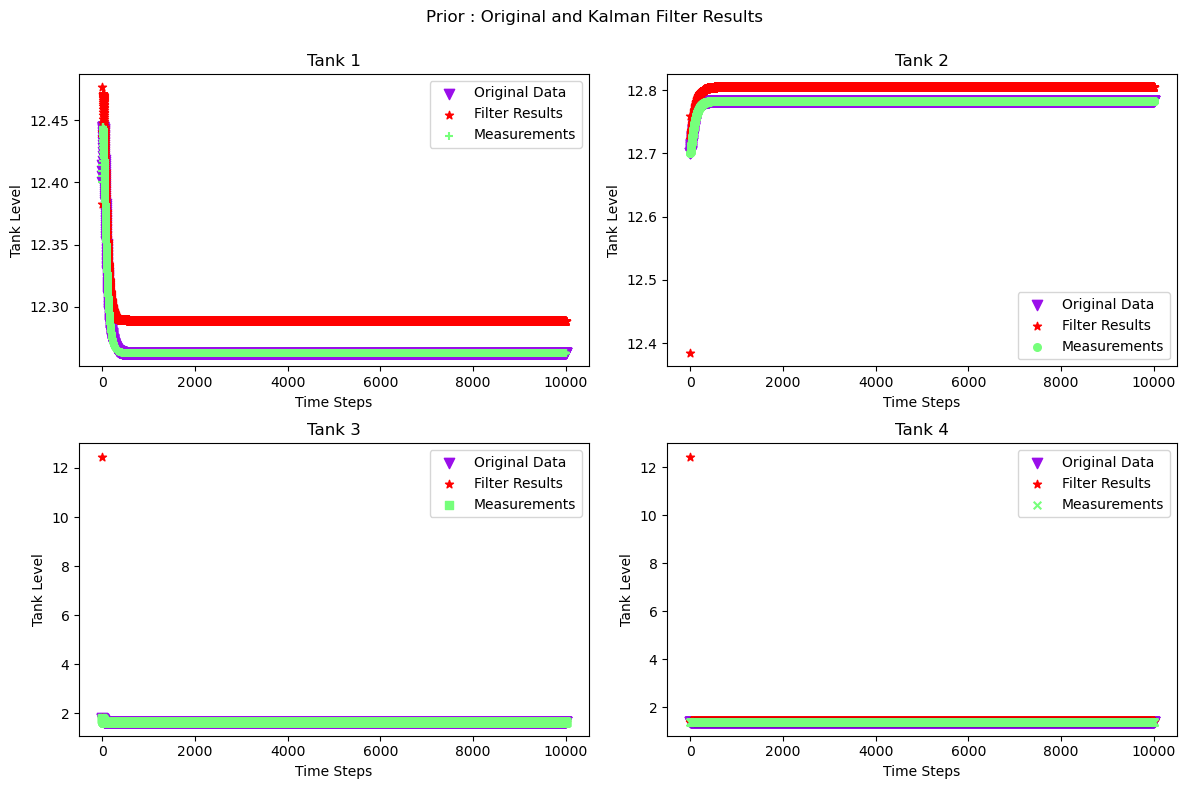

In [227]:
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[0:10000], X_prior_tank1, tank1_measurements[0:10000], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[0:10000], X_prior_tank2, tank2_measurements[0:10000], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[0:10000], X_prior_tank3, tank3_measurements[0:10000], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[0:10000], X_prior_tank4, tank4_measurements[0:10000], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Posterior Plots

In [228]:
# Initialize the plot for Posterior : Original and Kalman Filter Results
X_posterior_tank1 = [X_posterior_store[i][0][0] for i in range(10000)]
X_posterior_tank2 = [X_posterior_store[i][1][0] for i in range(10000)]
X_posterior_tank3 = [X_posterior_store[i][2][0] for i in range(10000)]
X_posterior_tank4 = [X_posterior_store[i][3][0] for i in range(10000)]

In [229]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_posterior_tank1)}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_posterior_tank2)}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_posterior_tank3)}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_posterior_tank4)}')

Tank 1 : Posterior Estimate : 12.26486417337239
Tank 2 : Posterior Estimate : 12.782325188106169
Tank 3 : Posterior Estimate : 1.6515457627119896
Tank 4 : Posterior Estimate : 1.419863606101535


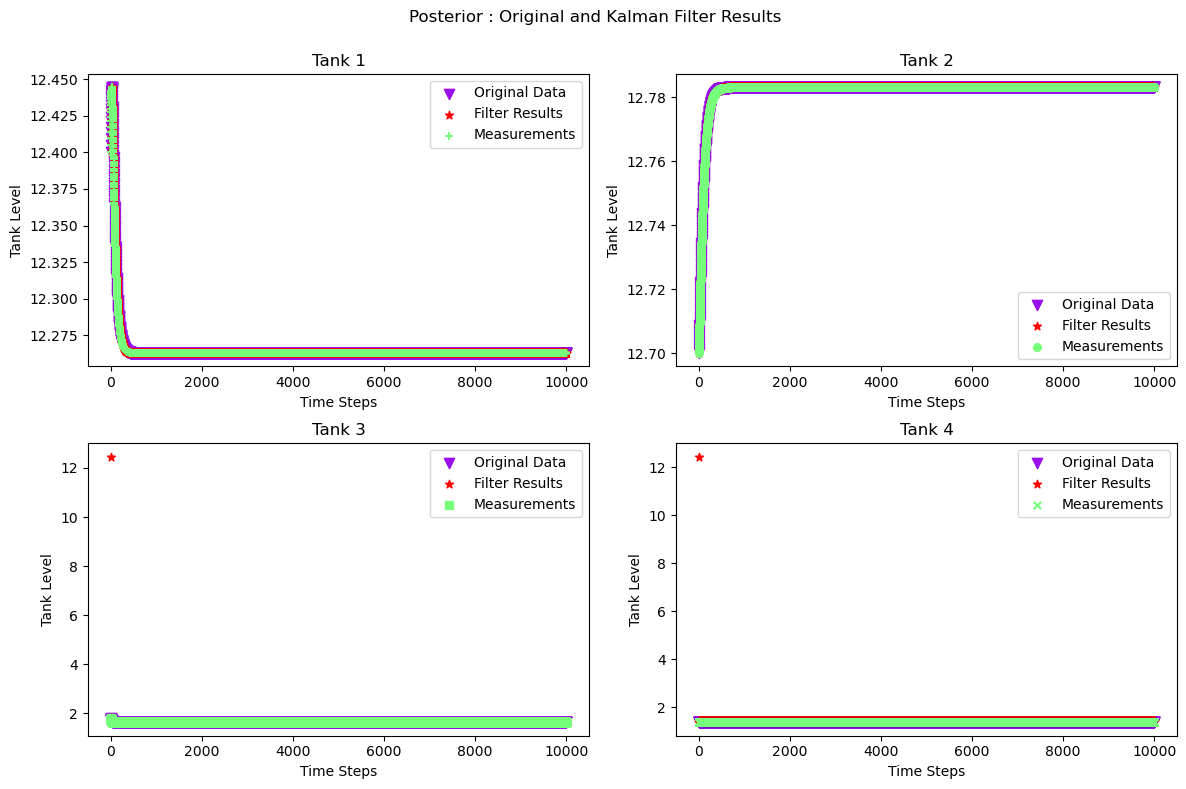

In [230]:
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior : Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[0:10000], X_posterior_tank1, tank1_measurements[0:10000], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[0:10000], X_posterior_tank2, tank2_measurements[0:10000], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[0:10000], X_posterior_tank3, tank3_measurements[0:10000], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[0:10000], X_posterior_tank4, tank4_measurements[0:10000], 'Tank 4', 'x')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Residue plots

In [231]:
# Initialize the plot for Residual
resid_h1 = [Residue_store[i][0][0] for i in range(10000)]
resid_h2 = [Residue_store[i][1][0] for i in range(10000)]

In [232]:
print(f'Tank 1 : Residual Mean Value : {np.mean(resid_h1)}')
print(f'Tank 2 : Residual Mean Value : {np.mean(resid_h2)}')

Tank 1 : Residual Mean Value : 6.13242999527484
Tank 2 : Residual Mean Value : 6.391160889889368


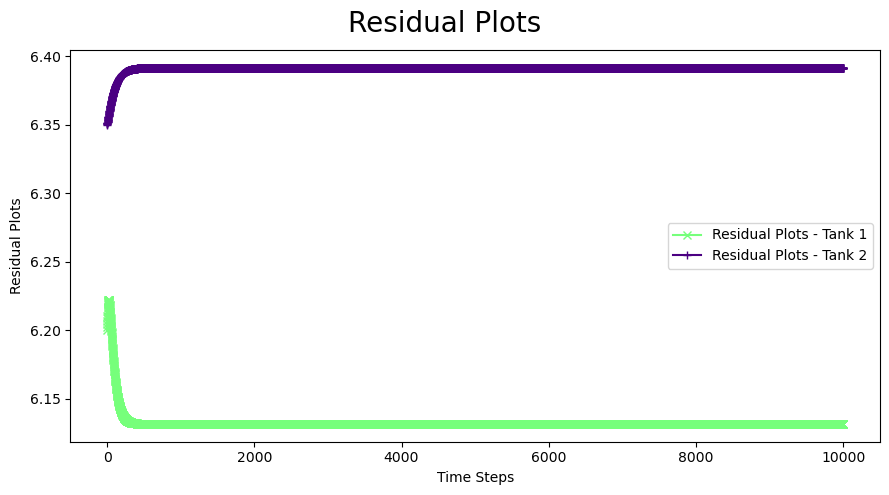

In [248]:
plotGraphicalData(1, time_steps_10000, [resid_h1, resid_h2], ['x', '+'], ['Residual Plots', 'Residual Plots'], ['#76FF7B', '#4B0082'], 'Residual Plots', ['Residual Plots - Tank 1', 'Residual Plots - Tank 2'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Innovation plots

In [249]:
# Initialize the plot for innovation
innov_h1 = [Innovation_store[i][0][0] for i in range(10000)]
innov_h2 = [Innovation_store[i][1][0] for i in range(10000)]

In [236]:
print(f'Tank 1 : Innovation Mean Value : {np.mean(innov_h1)}')
print(f'Tank 2 : Innovation Mean Value : {np.mean(innov_h2)}')

Tank 1 : Innovation Mean Value : -0.013072561526982593
Tank 2 : Innovation Mean Value : -0.010651613293010504


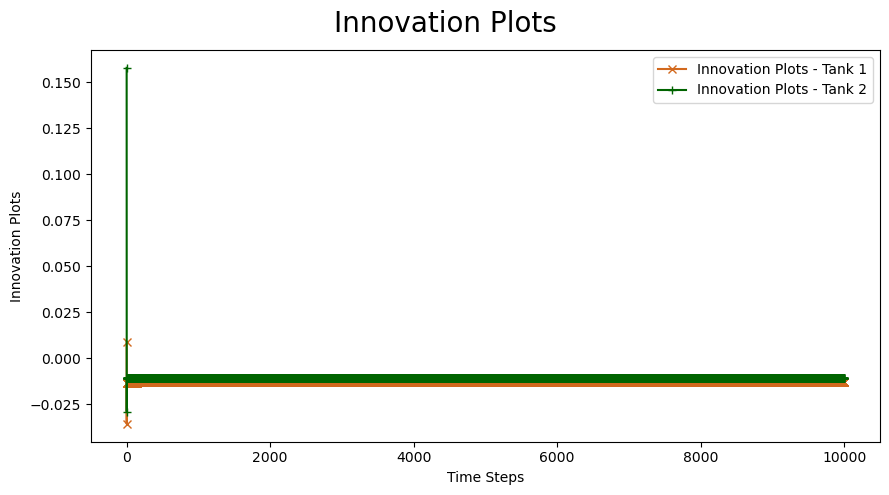

In [250]:
plotGraphicalData(1, time_steps_10000, [innov_h1, innov_h2], ['x', '+'], ['Innovation Plots', 'Innovation Plots'], ['#D2691E', '#006400'], 'Innovation Plots', ['Innovation Plots - Tank 1', 'Innovation Plots - Tank 2'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Prior process noise covariances trace plot

In [251]:
P_prior_plot = [P_prior_store[i] for i in range(10000)]

In [252]:
print(f'Prior process noise covariances : {P_prior_plot}')

Prior process noise covariances : [206.10565747881884, 200.00294790868628, 200.00286440780644, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.002864406498, 200.0

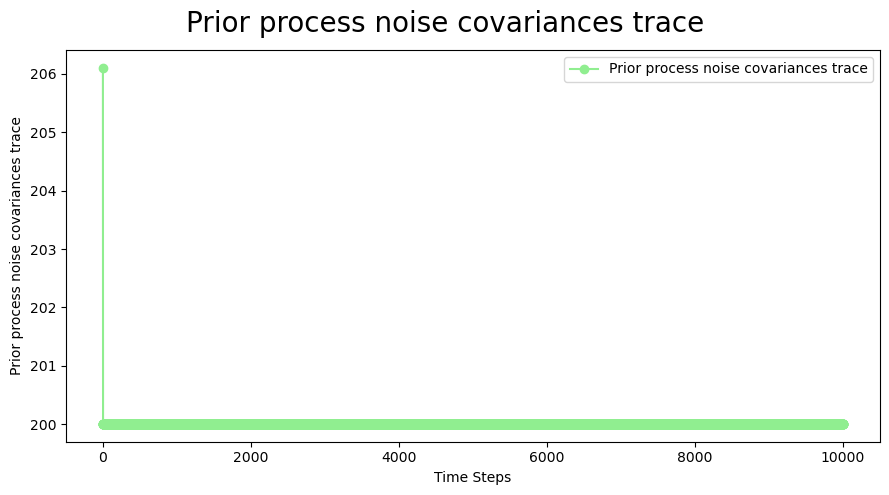

In [253]:
plotSingularData(1, time_steps_10000, np.array(P_prior_plot), 'o', 'Prior process noise covariances trace', '#90EE90')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Posterior process noise covariances trace plot

In [254]:
P_posterior_plot = [P_posterior_store[i] for i in range(10000)]

In [255]:
print(f'Posterior-measurement state covariances : {P_posterior_plot}')

Posterior-measurement state covariances : [102.78917113634387, 100.00947328278004, 100.00943153488839, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.00943153423424, 100.0094315342342

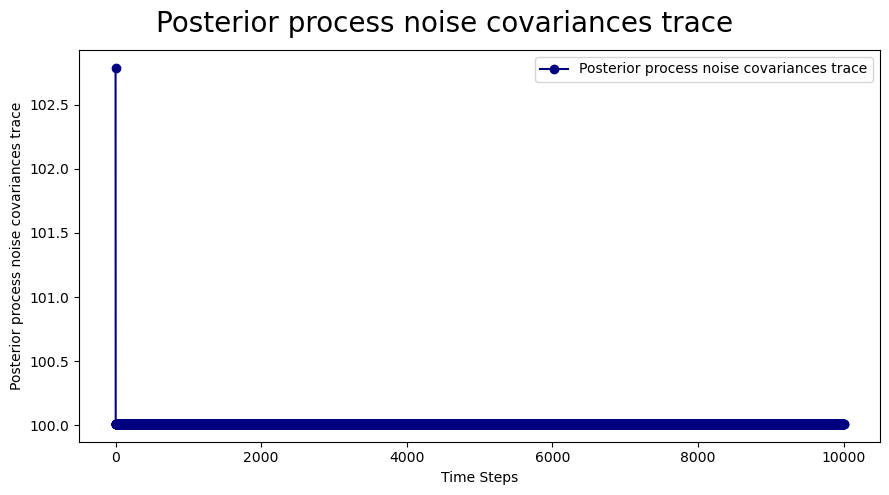

In [256]:
plotSingularData(1, time_steps_10000, np.array(P_posterior_plot), 'o', 'Posterior process noise covariances trace', '#000080')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Prior & Posterior state covariances trace plots

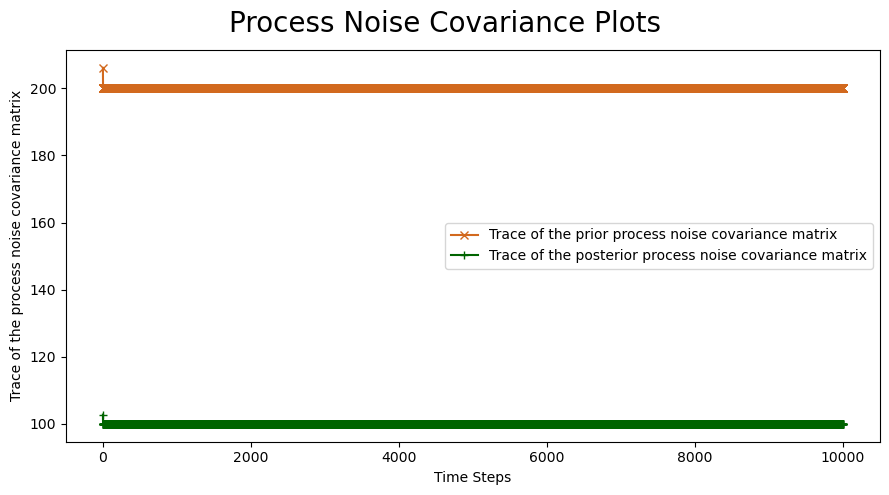

In [260]:
plotGraphicalData(1, time_steps_10000, [P_prior_plot, P_posterior_plot], ['x', '+'], ['Trace of the process noise covariance matrix','Trace of the process noise covariance matrix'], ['#D2691E', '#006400'], 'Process Noise Covariance Plots', ['Trace of the prior process noise covariance matrix', 'Trace of the posterior process noise covariance matrix'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#### Kalman plots

In [245]:
Kalman_Gain_trace_plot = [Kalman_Gain_store[i] for i in range(10000)]

In [246]:
print(f'Kalman Gain : Trace Value : {Kalman_Gain_trace_plot}')

Kalman Gain : Trace Value : [3.9996900532168365, 3.9996800303138063, 3.999680030180227, 3.999680030180225, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.9996800301802247, 3.99968003018

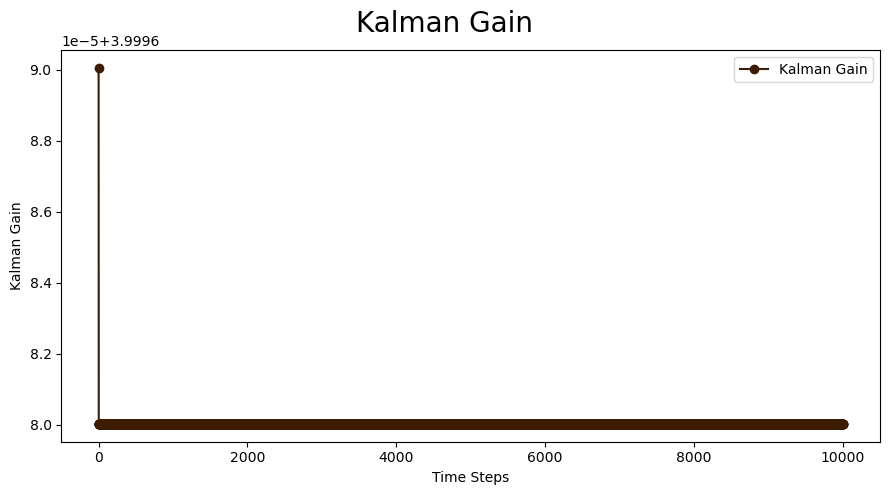

In [261]:
plotSingularData(1, time_steps_10000, np.array(Kalman_Gain_trace_plot), 'o', 'Kalman Gain', '#3D1C02')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Kalman Filter Result

In [267]:
tank1_measurements[:10000].shape, np.array(X_posterior_tank1).shape

((10000,), (10000,))

In [269]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps_10000,
    'Original_Tank1_Reading': tank1_measurements[:10000],
    'KalmanFilter_Tank1_Estimate': np.array(X_posterior_tank1),
    'Original_Tank2_Reading': tank2_measurements[:10000],
    'KalmanFilter_Tank2_Estimate': np.array(X_posterior_tank2),
    'Original_Tank3_Reading': tank3_measurements[:10000],
    'KalmanFilter_Tank3_Estimate': np.array(X_posterior_tank3),
    'Original_Tank4_Reading': tank4_measurements[:10000],
    'KalmanFilter_Tank4_Estimate': np.array(X_posterior_tank4),
})

# Display the dataframe
display(results_dataframe)


,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate
0,0,12.400000,12.399999,12.700000,12.699975,1.800000,12.459840,1.400000,12.439819
1,1,12.404928,12.404933,12.700618,12.700623,1.792881,1.764262,1.400301,1.373496
2,2,12.409478,12.409481,12.701239,12.701241,1.786060,1.802188,1.400592,1.410694
3,3,12.413670,12.413672,12.701863,12.701865,1.779526,1.795469,1.400873,1.410858
4,4,12.417521,12.417523,12.702490,12.702491,1.773266,1.789213,1.401145,1.411136
...,...,...,...,...,...,...,...,...,...
9995,9995,12.262968,12.262970,12.783158,12.783160,1.633941,1.650105,1.409045,1.418789
9996,9996,12.262968,12.262970,12.783158,12.783160,1.633941,1.650105,1.409045,1.418789
9997,9997,12.262968,12.262970,12.783158,12.783160,1.633941,1.650105,1.409045,1.418789
9998,9998,12.262968,12.262970,12.783158,12.783160,1.633941,1.650105,1.409045,1.418789


#### Saving the compared data between Kalman filter estimates

In [ ]:
results_dataframe.to_csv('Comparison_Kalman.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion :**



<h3 style='text-align: center;'>=======================End of Mini Project Kalman Filter=======================</h3>